In [34]:
# début du projet python - version avec la visualisation graphique des cartes

# Projet Python 2A : Performance énergétique des logements en France et caractéristiques socioéconomiques

Ce projet a pour but d’analyser la performance énergétique des logements en France métropolitaine (hors Corse) a une échelle départementale d’un point de vue socioéconomique. Il mettra en regard les caractéristiques des logements, les caractéristiques géographiques des départements étudiés mais également les caractéristiques socioéconomiques des habitants pour comprendre dans quelle mesure elles sont liées entre elles. Il sera réalisé à l’aide des données Insee et de données de l’Ademe et du ministère de la Transition Ecologique (a compléter modifier ex : ign si on a besoin de données géo, edf conso électrique etc. ).
# a reprendre

# Introduction

In [1]:
# idée afficher une image / mème de Bruno Le Maire et de son col roulé 

L'augmentation des prix de l'énergie en 2022 ainsi que les risques de pénuruie notamment dus à la guerre en Ukraine, on conduit le ministre de l'Economie en France à suggérer aux français de baisser leur chauffage et de porter des cols roulés. 

Cela nous a donc amené à questionner la consommation énergétique des français, et en particulier, celle de leur logement. 
A partir des données de diagnostique de performance énergétique (DPE) des logements en France métropolitaine (hors Corse) issues de l'Agence de la transition écologique (Ademe), retraitées et augmentées par le ministère de la Transition Ecologique à partir de données sociofiscale produite par l'Institut National des Statistiques et des Etudes Economique (Insee, données filosofi) il est possible d'étudier le lien entre performance énergétique des logements et caractéristiques socioéconomiques du territoires et des habitants. En effet, le DPE, instauré en 2006 et obligatoire lors de la vente ou de la location d'un logement, est un indicateur de la performance énergétique et climatique à destination de l'ensemble des français mais également un outil des politiques publiques environementales. Il permet par exemple de repérer les passoires thermiques. 

L’analyse de la performance énergétique des bâtiments permet de contribuer à répondre à une demande citoyenne et politique. Dans le cadre de la transition écologique, elle représente un indicateur des politiques de rénovations à mener, et compte tenue de la mise jours des données, d’un suivi de cette même politique. En poursuivant l’étude sous un angle socioéconomique, le projet donne également à voir les différences territoriales, sociale et économique en termes de performance énergétique des logements et permet donc en partie d’évaluer sous le prisme des inégalités et de la redistribution les politiques récentes menées par le gouvernement : prime à la rénovation sous condition de revenu, obtention d’une note minimale au DPE pour mettre en location son logement etc. Ainsi, précrarité erngétique et précarité monétaire sont elles dépendantes ? 

L'étude est réalisée à l'échelle départementale. Plusieurs variables semblent pertinentes pour répondre à cette problématique

- Les caractéristiques du logement : type de logement, surface, date de construction, 
- Les cractéristiques des habitants : parc locatif (peut être a mettre en interaction avec le type de logement), statut d’occupation, revenus par quartile 
- La situation géographique : voir si l’on complète avec des données autres (ign/insee) : part de rural, zone d’emploi, températures, altitudes ; on peut aussi éventuellement essayer de faire parler des cartes en récupérant des données socioéconomiques à un niveau départemental qui nous manquerait (taux de chômage, taux de famille monoparentale, proportion de personne âgés, proportion d’enfants, proportions d’étudiants – qui peuvent être des publics cibles)


# 1. Descriptions des sources de données et de leurs récupérations 

## 1.1. Instalation des packages nécessaires

# Attention, a mettre à jour à chaque fois 

In [2]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

In [3]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [4]:
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.23.26 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.22 which is incompatible.
boto3 1.25.1 requires botocore<1.29.0,>=1.28.1, but you have botocore 1.23.26 which is incompatible.
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.22
    Uninstalling urllib3-1.22:
      Successfully uninstalled urllib3-1.22
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.25.1 requ

In [5]:
#!pip install pathlib2
#!pip install python-Levenshtein
#!pip install --upgrade xlrd
#!pip install git+https://github.com/InseeFrLab/Py-Insee-Data.git
!pip install requests
!pip install openpyxl 
!pip install xlrd==1.2.0

On importe ensuite les modules :

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pynsee
#import pynsee.download
import requests
import cartiflette.s3

## 1.2. Autour des données 

### 1.2.1. Importation des données

#### Niveau national 

On commence par importer les données relatives au DPE issues du site du Service des Données et Etudes Statistiques (SDES) du ministère de la Transistion Ecologique. Nous allons travailler pour commencer sur les données nationale, en particulier sur l'onglet "Données locales - départements". 
L'affichage de la base de donnée permet de vérifier que ce dernier c'est bien passé. Cela donne aussi un premier apperçu du nettoyage qui ser ensuite nécessaire. 

In [7]:
url = 'https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-10/parc_logements_dpe_2018.xlsx'
s = requests.get(url).content

xl = pd.ExcelFile(s)  # io.BytesIO(s) is also work
xl.sheet_names        # see all sheet names

df_bdd_nat = xl.parse('Données locales - départements', nrows = 94, header = 0) 

In [8]:
df_bdd_nat.head(5)

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G
0,1,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798
1,2,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402
2,3,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668
3,4,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997
4,5,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821


On recommence la procédure pour récupérer les informations relatives aux occupants et les logements au niveau national

In [9]:
df_log_nat = xl.parse('Logements', nrows = 52, header = 0)  
df_hab_nat = xl.parse('Occupants', nrows = 30, header = 0) 
df_hab_nat_enrjvore = xl.parse('Occupants - graphiques', nrows = 4, header = 7) 

In [10]:
df_log_nat.head(5)

,Type de logement,A,B,C,D,E,F,G,Total général
0,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nombre,220866.148373,756984.869021,2576265.264322,4719173.51348,2836949.710115,1197256.277384,717023.277109,13024519.059803
2,Taux,0.016958,0.05812,0.197801,0.36233,0.217816,0.091923,0.055052,1
3,Maison individuelle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nombre,298924.906133,613438.433528,2584832.265549,5072271.385708,4155781.38316,1878785.934819,991794.6313,15595828.940197


In [11]:
df_hab_nat.head(5)

,Revenus / Statut d'occupation,A,B,C,D,E,F,G,Total général
0,Parc locatif privé,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nombre,76799.722014,234225.796089,744257.145276,1.679471e+06,1.329241e+06,696957.355394,509082.348610,5.270034e+06
3,Taux,0.014573,0.044445,0.141224,3.186831e-01,2.522262e-01,0.132249,0.096599,1.000000e+00
4,Maison individuelle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_hab_nat_enrjvore.head(5)

,Unnamed: 0,Locataire (parc privé),Locataire (parc social),Propriétaires,Ensemble
0,1er quintile,0.278,0.070,0.233,0.193
1,2nd quintile,0.217,0.069,0.206,0.176
2,3e quintile,0.197,0.067,0.177,0.165
3,4e quintile,0.198,0.070,0.154,0.156


#### Niveau local 

On travaille également à un niveau local, départemental. 
Les données que l'on peut télécharger sur le site du SDES doivent être concaténées pour être exploitées.

In [13]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd

resp = urlopen("https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2021-02/parc_par_departement_dpe_2018.zip") #on récupère le fichier zip par un lien
zipfile = ZipFile(BytesIO(resp.read()))
nom=ZipFile.namelist(zipfile) #on trouve la liste de noms de fichiers (excel et txt) dont on se servira plus tard

for i in range(95):
  def extracted_file(i): #on crée une variable qui permet d'extraire un excel parmi la namelist
    return zipfile.open(nom[i]) #ouvre le département i, il faut aller de 1 jusqu'à 95 (nombre de départements étudiés, le fichier en position 0 étant un texte d'information)

for i in range(95):
  def choix1(i):
    return pd.ExcelFile(extracted_file(i))

for i in range(95):
  def choix2(i):
    return choix1(i).parse('Occupation et revenus', nrows = 10, header = 0)

S = choix2(1)  #le premier élément
for i in range(1, 95):  
 S = pd.concat([S,choix2(i)])

S

,DEP,OCC,REVENUS,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,Locataire - parc HLM,D1 à D3,324.404080,1545.536239,6404.870042,7508.319062,3730.624055,1133.053030,307.000349
1,1,Locataire - parc locatif privé,D1 à D3,123.595363,502.992508,1819.079951,3112.031814,3127.409602,1616.051224,2051.683007
2,1,Occupant à titre gratuit,D1 à D3,16.284121,32.070424,68.664486,102.007356,96.566843,34.301831,7.797733
3,1,Propriétaire,D1 à D3,167.909655,551.009745,2752.477561,5305.512891,4791.113743,2907.120498,2470.099628
4,1,Locataire - parc HLM,D4 à D7,411.657927,2006.901431,5701.623439,6217.114623,3321.169755,1003.426913,280.779967
...,...,...,...,...,...,...,...,...,...,...
5,95,Locataire - parc locatif privé,D4 à D7,500.739350,2355.223455,3459.673129,9976.833016,9934.025581,3868.944929,3025.936943
6,95,Occupant à titre gratuit,D4 à D7,26.503708,98.059362,222.475850,393.658948,242.820408,65.085265,20.206081
7,95,Propriétaire,D4 à D7,810.917589,2927.026457,9378.308174,33331.971790,31203.872455,11359.040989,5227.466068
8,95,Locataire - parc HLM,D8 à D10,137.647983,963.844647,3182.585679,5928.194019,2835.631044,821.703809,321.416465


### 1.2.2. Traitement des bases de données

#### La base DPE nationale 

Plusieurs traitements sont necessaires pour exploiter la base DPE nationale. 
On vérifie qu'il n'y a pas de valeurs manquantes.

In [14]:
# Affichage des valeurs nulles
print(df_bdd_nat.isnull())

    Département      A      B      C      D      E      F      G  Taux_A  \
0         False  False  False  False  False  False  False  False   False   
1         False  False  False  False  False  False  False  False   False   
2         False  False  False  False  False  False  False  False   False   
3         False  False  False  False  False  False  False  False   False   
4         False  False  False  False  False  False  False  False   False   
..          ...    ...    ...    ...    ...    ...    ...    ...     ...   
89        False  False  False  False  False  False  False  False   False   
90        False  False  False  False  False  False  False  False   False   
91        False  False  False  False  False  False  False  False   False   
92        False  False  False  False  False  False  False  False   False   
93        False  False  False  False  False  False  False  False   False   

    Taux_B  Taux_C  Taux_D  Taux_E  Taux_F  Taux_G  
0    False   False   False   False

On va faire quelques statistiques descriptives simples pour vérifier qu'il n'y ait pas de valeurs abérantes.

In [15]:
df_bdd_nat.describe()

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,48.297872,5203.568042,14500.450321,54516.444424,103796.229721,74199.764835,32656.381216,18173.455028,0.015893,0.041316,0.161465,0.325177,0.255942,0.122758,0.077449
std,27.561790,6463.463094,14533.114230,53465.600998,88462.641064,54811.957701,25358.152106,15595.670559,0.011398,0.017564,0.057018,0.044485,0.041557,0.037433,0.049142
min,1.000000,91.900218,598.777581,3249.342024,8661.063024,7836.279532,4620.566918,1125.109024,0.001263,0.011176,0.054961,0.198765,0.145009,0.047204,0.006243
25%,25.250000,1305.761969,3711.609865,16523.120222,40339.762451,36195.777590,17142.564133,8763.627658,0.006792,0.029399,0.117163,0.295006,0.242916,0.100468,0.047091
50%,48.500000,3030.033853,9728.120472,37415.272376,75038.956085,60785.380102,27371.186448,15360.810434,0.012764,0.038522,0.153256,0.324655,0.263654,0.122788,0.071155
75%,71.750000,6492.121174,21365.772103,68876.042717,140153.412273,95204.395203,40344.216735,22978.624334,0.024182,0.049174,0.183485,0.355764,0.285487,0.148638,0.106305
max,95.000000,32411.438272,62308.598976,270902.771292,443890.792647,301892.731433,198800.346428,128932.816738,0.047185,0.111625,0.324565,0.425478,0.327978,0.215789,0.260148


Il n'y a pas de résultats choquants (des pourcentages supérieurs à 100) ou encore une quantité de logement démeusurée (par exemple). On retrouve également le bon nombre de département en France métropolitaine. 

On va donc passer à la construction de nouvelles variables. Pour cela on va créer une version "work" de la base de données. 

On va rajouter une colonne qui donne le DPE moyen pour chaque département.
On convient que le DPE A vaut 1 et que le DPE G faut 7, de sorte que plus le score obtenu est petit, meilleurs sont les logements du département.

In [16]:
DPE_moy=[]
nb_dep=len(df_bdd_nat) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_dep):
    DPE_score=0
    DPE_score=df_bdd_nat.iloc[i]["Taux_A"]*1+df_bdd_nat.iloc[i]["Taux_B"]*2+df_bdd_nat.iloc[i]["Taux_C"]*3+df_bdd_nat.iloc[i]["Taux_D"]*4+df_bdd_nat.iloc[i]["Taux_E"]*5+df_bdd_nat.iloc[i]["Taux_F"]*6+df_bdd_nat.iloc[i]["Taux_G"]*7
    DPE_moy.append(DPE_score)

df_bdd_nat_work=df_bdd_nat.copy(deep=True)

On concatène ci-dessous

In [17]:
df_bdd_nat_work=df_bdd_nat_work.assign(DPE_Moyen=DPE_moy)
# Vérifions que cela marche
df_bdd_nat_work.head(5)

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen
0,1,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929
1,2,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776
2,3,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923
3,4,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268
4,5,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483


On introduit également une colonne qui donne le total des logements par département. Le nombre de logement par département n'étant, a priori, pas la même, il se pourrait que la performance énergétique varie en fonction du nombre de logement. 

In [18]:
Log_tot=[]
nb_dep=len(df_bdd_nat) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_dep):
    Log_nb=0
    Log_nb=df_bdd_nat.iloc[i]["A"]+df_bdd_nat.iloc[i]["B"]+df_bdd_nat.iloc[i]["C"]+df_bdd_nat.iloc[i]["D"]+df_bdd_nat.iloc[i]["E"]+df_bdd_nat.iloc[i]["F"]+df_bdd_nat.iloc[i]["G"]
    Log_tot.append(Log_nb)

df_bdd_nat_work=df_bdd_nat_work.assign(Log_totaux=Log_tot)
# Vérifions que cela marche
df_bdd_nat_work.head(5)

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux
0,1,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929,258483.631907
1,2,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776,210946.014793
2,3,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923,159514.193454
3,4,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268,73670.595441
4,5,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483,58783.739909


Pour plus de lisibilité on renomme également les départements. On décide également de centrer l'analyse sur les départements de France métropolitaine hors Corses. En effet les départements situés dans les DOM et la Corse peuvent présenter des spécificités (climat, matériaux de constructions, etc) qui pourraient bruiter l'analyse.

In [19]:
url2 = 'https://www.business-plan-excel.fr/wp-content/uploads/2021/05/Liste-Excel-des-departements-francais.xlsx'
s2 = requests.get(url2).content

xl2 = pd.ExcelFile(s2)  # io.BytesIO(s) is also work
xl2.sheet_names        # see all sheet names

df_dep = xl2.parse('Départements français', nrows = 100, header = 0) 

In [20]:
df_dep.head(35)

,N°,Département,Chef-lieu,Région
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur
5,06,Alpes-Maritimes,Nice,Provence-Alpes-Côte d'Azur
6,07,Ardèche,Privas,Auvergne-Rhône-Alpes
7,08,Ardennes,Charleville-Mézières,Grand Est
8,09,Ariège,Foix,Occitanie
9,10,Aube,Troyes,Grand Est


In [21]:
# on se restreint à la france métropolitaine 
df_dep=df_dep.drop(labels=None, axis=0, index=20)
df_dep=df_dep.drop(labels=None, axis=0, index=19)
df_dep=df_dep.drop(labels=None, axis=0, index=96)
df_dep=df_dep.drop(labels=None, axis=0, index=97)
df_dep=df_dep.drop(labels=None, axis=0, index=98)
df_dep=df_dep.drop(labels=None, axis=0, index=99)

In [22]:
len(df_dep)

94

In [23]:
df_bdd_nat_work.insert(1, "Département_nom",df_dep['Département'].tolist()) 
#on met la colonne vers le début du tableau

In [24]:
# Vérifions que cela marche
df_bdd_nat_work.head(35)

,Département,Département_nom,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux
0,1,Ain,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929,258483.631907
1,2,Aisne,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776,210946.014793
2,3,Allier,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923,159514.193454
3,4,Alpes-de-Haute-Provence,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268,73670.595441
4,5,Hautes-Alpes,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483,58783.739909
5,6,Alpes-Maritimes,11815.026075,32741.704372,168053.460347,212556.098431,87111.472985,31651.723590,10705.936616,0.021302,0.059033,0.302998,0.383236,0.157061,0.057068,0.019303,3.844133,554635.422416
6,7,Ardèche,3450.067924,4613.980259,20072.427238,35529.974523,36784.778591,18058.046289,17657.344298,0.025337,0.033885,0.147411,0.260930,0.270145,0.132617,0.129675,4.633212,136166.619123
7,8,Ardennes,357.615108,3440.964517,13073.048430,36849.557201,37741.272738,17002.884673,10990.062443,0.002994,0.028805,0.109439,0.308480,0.315944,0.142337,0.092001,4.700591,119455.405111
8,9,Ariège,729.642493,1878.391779,11710.841827,18670.598620,16823.926953,8738.068679,5995.503357,0.011304,0.029101,0.181431,0.289256,0.260646,0.135375,0.092886,4.536509,64546.973707
9,10,Aube,598.450763,4300.754525,20864.624123,40957.694112,37944.387099,18652.026934,11393.319615,0.004442,0.031926,0.154884,0.304041,0.281672,0.138459,0.084576,4.580255,134711.257171


#### La base logement nationale 

On passe ensuite à la base relative aux caractéristiques du logement. La base récupérée initialement sur le site du SDES contient plusieurs informations plus ou moins nécessaires. 
Nous choisissons d'en retenir qu'une partie, soit la proportion pour chaque type de DPE de logement selon le type, la surface et l'année de construction afin de voir dans un second teps (partie 2) si par exemple les appartements sont plus souvent mal classés, ou enore les logements les plus anciens etc.

In [25]:
#df_log_nat

In [26]:
df_log_nat_work = df_log_nat.copy()
#sur le type de logement
df_log_nat_work.iloc[2,0]="taux_app"
df_log_nat_work.iloc[5,0]="taux_maison"
df_log_nat_work.iloc[7,0]="taux_ens"
#sur la surface
df_log_nat_work.iloc[12,0]="taux_sm30"
df_log_nat_work.iloc[15,0]="taux_s3060"
df_log_nat_work.iloc[18,0]="taux_s60100"
df_log_nat_work.iloc[21,0]="taux_sp1000"
df_log_nat_work.iloc[23,0]="taux_sens"
#sur la date de construction 
df_log_nat_work.iloc[28,0]="taux_dm1919"
df_log_nat_work.iloc[31,0]="taux_d1945"
df_log_nat_work.iloc[34,0]="taux_d4874"
df_log_nat_work.iloc[37,0]="taux_d7588"
df_log_nat_work.iloc[40,0]="taux_d8900"
df_log_nat_work.iloc[43,0]="taux_d0105"
df_log_nat_work.iloc[46,0]="taux_d0611"
df_log_nat_work.iloc[49,0]="taux_d1218"
df_log_nat_work.iloc[51,0]="taux_dens"
#on supprime les lignes inutiles 
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=0)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=1)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=3)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=4)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=6)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=8)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=9)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=10)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=11)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=13)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=14)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=16)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=17)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=19)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=20)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=22)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=24)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=25)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=26)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=27)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=29)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=30)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=32)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=33)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=35)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=36)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=38)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=39)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=41)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=42)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=44)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=45)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=47)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=48)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=50)
df_log_nat_work
#on transpose #
#df_log_nat_work_T=df_log_nat_work.transpose()
#df_log_nat_work_T_df

,Type de logement,A,B,C,D,E,F,G,Total général
2,taux_app,0.016958,0.05812,0.197801,0.36233,0.217816,0.091923,0.055052,1
5,taux_maison,0.019167,0.039333,0.165739,0.325233,0.266467,0.120467,0.063594,1
7,taux_ens,0.018162,0.047883,0.18033,0.342115,0.244327,0.107477,0.059706,1
12,taux_sm30,0.00736,0.027653,0.079269,0.248638,0.278067,0.198956,0.160057,1
15,taux_s3060,0.016078,0.04675,0.141228,0.328343,0.251525,0.129165,0.08691,1
18,taux_s60100,0.017969,0.048507,0.186974,0.350237,0.244847,0.102062,0.049405,1
21,taux_sp1000,0.021579,0.050554,0.21246,0.351874,0.233284,0.087534,0.042717,1
23,taux_sens,0.018162,0.047883,0.18033,0.342115,0.244327,0.107477,0.059706,1
28,taux_dm1919,0.004565,0.004006,0.073835,0.224582,0.269042,0.221745,0.202225,1
31,taux_d1945,0.003448,0.003039,0.067223,0.259646,0.307713,0.191665,0.167266,1


#### La base habitants nationale 

Les données disponibles sur les caractéristiques des habitants des logements sont disponibles dans deux onglets du fichier initial. Le tableau relatif au revenu des habitants des passoirs thermiques ne necessite pas de retraitement, en revanche les informations qui permettent de croiser DPE, statut d'occupation et types de logements doivent être retravaillées. Nous allons conserver que les proportions de chaque type selon le DPE comme pour la base logement. 

In [27]:
df_hab_nat_work = df_hab_nat.copy()
df_hab_nat_work
#Parmi le parc locatif privé 
df_hab_nat_work.iloc[3,0]="taux_app_locpriv"
df_hab_nat_work.iloc[6,0]="taux_maison_locpriv"
df_hab_nat_work.iloc[8,0]="taux_ens_locpriv"
#Parmi le parc locatif social 
df_hab_nat_work.iloc[12,0]="taux_app_locsoc"
df_hab_nat_work.iloc[15,0]="taux_maison_locsoc"
df_hab_nat_work.iloc[17,0]="taux_ens_locsoc"
#Parmi les propriétaires occupants
df_hab_nat_work.iloc[21,0]="taux_app_proprio"
df_hab_nat_work.iloc[24,0]="taux_maison_proprio"
df_hab_nat_work.iloc[26,0]="taux_ens_proprio"
#on supprime les lignes inutiles 
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=0)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=1)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=2)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=4)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=5)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=7)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=9)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=10)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=11)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=13)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=14)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=16)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=18)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=19)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=20)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=22)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=23)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=25)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=27)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=28)
df_hab_nat_work
#on transpose 
#df_hab_nat_work_T=df_hab_nat_work.transpose()
#df_hab_nat_work_T

,Revenus / Statut d'occupation,A,B,C,D,E,F,G,Total général
3,taux_app_locpriv,0.014573,0.044445,0.141224,0.318683,0.252226,0.132249,0.096599,1.0
6,taux_maison_locpriv,0.023655,0.034447,0.135022,0.309958,0.270635,0.135816,0.090468,1.0
8,taux_ens_locpriv,0.017127,0.041633,0.139480,0.316230,0.257403,0.133252,0.094875,1.0
12,taux_app_locsoc,0.022488,0.082862,0.266688,0.399474,0.164226,0.049321,0.014941,1.0
15,taux_maison_locsoc,0.027300,0.069099,0.237641,0.327546,0.238209,0.081059,0.019145,1.0
17,taux_ens_locsoc,0.023306,0.080524,0.261754,0.387255,0.176794,0.054712,0.015655,1.0
21,taux_app_proprio,0.014747,0.052007,0.204576,0.384220,0.224597,0.080350,0.039502,1.0
24,taux_maison_proprio,0.017865,0.038195,0.166078,0.327509,0.267721,0.120371,0.062261,1.0
26,taux_ens_proprio,0.017151,0.041359,0.174897,0.340501,0.257842,0.111203,0.057048,1.0


# 2. Statistiques descriptives : titre à message 

## 2.1. Caractéristiques des logements

### 2.1.1. Exploration des caractéristiques des logements selon leur DPE
Pour analyser les informations contenues dans cette base, nous choisissons de réaliser des diagrammes et de comparer chaque catégorie à l'ensemble des logements.

<AxesSubplot: title={'center': 'Répartition des logements selon le DPE et leurs caractéristiques'}, xlabel='Type de logement'>

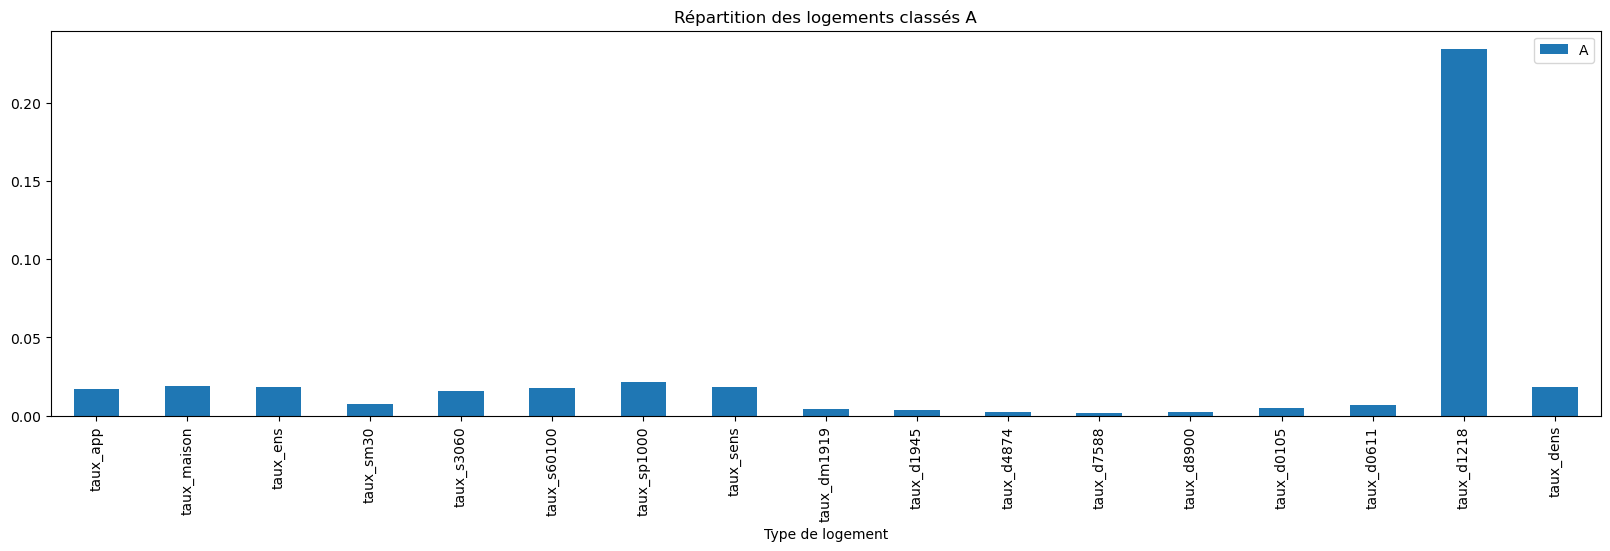

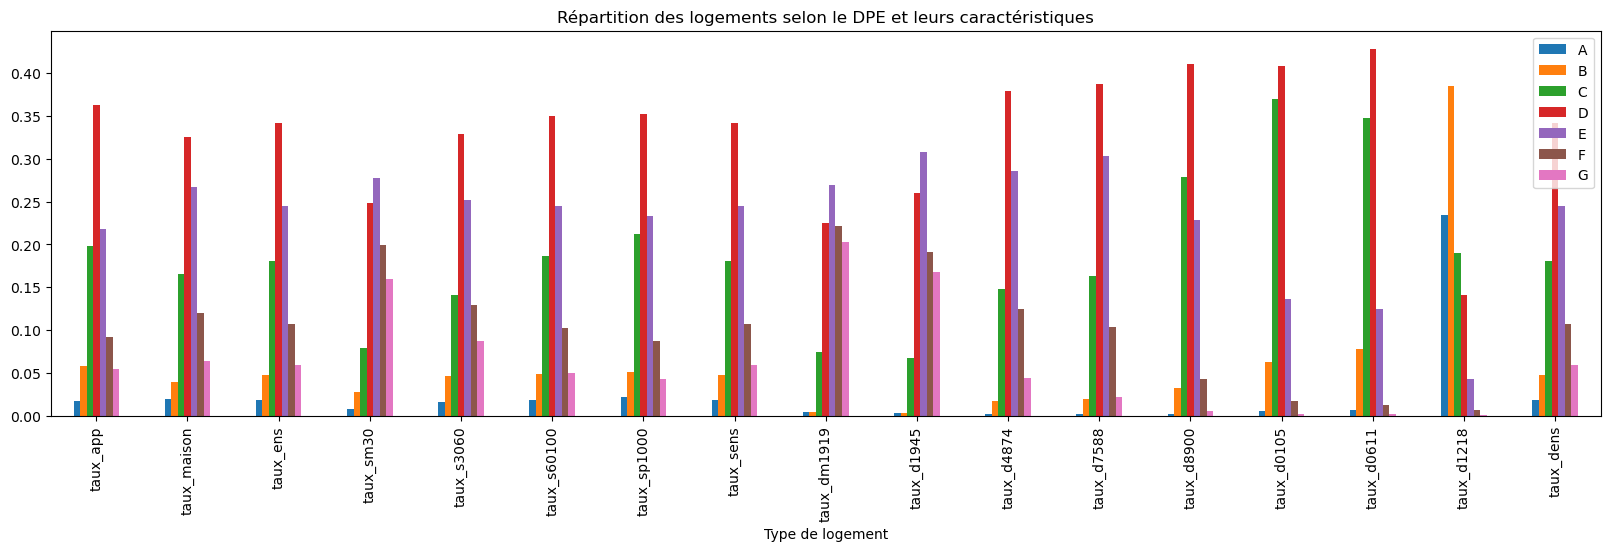

In [28]:
#représentation graphique des caractéristiques des logements selon leur DPE
df_to_plot_log1 = pd.DataFrame(df_log_nat_work,columns=['Type de logement','A','B','C','D','E','F','G'])
#df_to_plot_log1T = pd.DataFrame(df_log_nat_work_T,columns=['taux_app','taux_maison','taux_ens'])
df_to_plot_log1.plot(x ='Type de logement', y=['A'],kind = 'bar', figsize=(20,5), title="Répartition des logements classés A")
df_to_plot_log1.plot(x ='Type de logement', y=['A','B','C','D','E','F','G'],kind = 'bar', figsize=(20,5), title="Répartition des logements selon le DPE et leurs caractéristiques")

La lisibilité n'est pas très bonne, essayons de comparer les DPE selon que l'habitat soit une maison ou un appartement

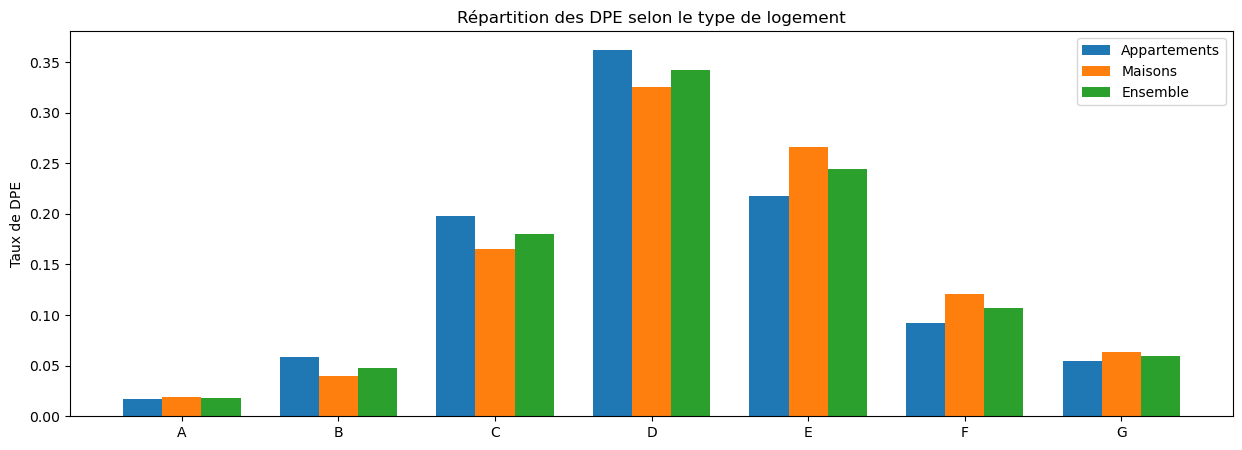

In [97]:
abscisse=['A','B','C','D','E','F','G']

#ci-dessous on traite les appartements, on passe par des listes pour pouvoir afficher tous les graphes sur une même ligne
dpe_app=liste=df_log_nat_work.loc[[2]].values.tolist()
dpe_app=dpe_app[0]
dpe_app.remove('taux_app')
dpe_app.pop()

#ci-dessous on traite les maisons
dpe_maison=liste=df_log_nat_work.loc[[5]].values.tolist()
dpe_maison=dpe_maison[0]
dpe_maison.remove('taux_maison')
dpe_maison.pop()

#ci-dessous l'ensemble
dpe_ens=liste=df_log_nat_work.loc[[7]].values.tolist()
dpe_ens=dpe_ens[0]
dpe_ens.remove('taux_ens')
dpe_ens.pop()

x = np.arange(len(abscisse))  # localisation des labels
width = 0.25  # taille des barres

fig, ax = plt.subplots()
appart = ax.bar(x - width, dpe_app, width, label='Appartements')
maison = ax.bar(x, dpe_maison, width, label='Maisons')
ensemble = ax.bar(x + width, dpe_ens, width, label='Ensemble')

ax.set_ylabel('Taux de DPE')
ax.set_title('Répartition des DPE selon le type de logement')
ax.set_xticks(x,abscisse)
ax.legend()
fig.set_size_inches(15, 5)

plt.show()

### Interprétation : des maisons plus énergivores

Un premier constat à effectuer est la répartition quasi normale des données de DPE, avec une queue de distribution plus importante pour les plus mauvais DPE (il y a relativement plus de F / G que de A / B)

Le second point d'intérêt est la meilleure isolation des appartements par rapport aux maisons (DPE des appartements plus performants en moyenne que ceux des maisons). Il est important de noter que pour chaque DPE, le DPE moyen (catégorie "ensemble") semble être issu d'une pondération quasi équivalente entre maisons et appartements. La conséquence de cela est que les efforts de rénovation énergétiques ne doivent pas être polarisés sur les maisons ou les appartements mais bien sur les deux types de logement

### 2.1.2. Etudions les passoires thermiques DPE F ou G

Commençons par calculer le pourcentage de passoires thermiques dans chaque département

In [98]:
# Derive New Column from Existing Column

df_bdd_nat_work=df_bdd_nat_work.assign(Taux_Passoires_Thermique=(df_bdd_nat_work['Taux_F']+df_bdd_nat_work['Taux_G'])*100)

In [99]:
df_bdd_nat_work.head(20)

,Département,Département_nom,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux,Taux_Passoires_Thermique
0,1,Ain,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929,258483.631907,18.219730
1,2,Aisne,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776,210946.014793,28.873883
2,3,Allier,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923,159514.193454,25.744696
3,4,Alpes-de-Haute-Provence,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268,73670.595441,29.176637
4,5,Hautes-Alpes,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483,58783.739909,29.757824
5,6,Alpes-Maritimes,11815.026075,32741.704372,168053.460347,212556.098431,87111.472985,31651.723590,10705.936616,0.021302,0.059033,0.302998,0.383236,0.157061,0.057068,0.019303,3.844133,554635.422416,7.637028
6,7,Ardèche,3450.067924,4613.980259,20072.427238,35529.974523,36784.778591,18058.046289,17657.344298,0.025337,0.033885,0.147411,0.260930,0.270145,0.132617,0.129675,4.633212,136166.619123,26.229182
7,8,Ardennes,357.615108,3440.964517,13073.048430,36849.557201,37741.272738,17002.884673,10990.062443,0.002994,0.028805,0.109439,0.308480,0.315944,0.142337,0.092001,4.700591,119455.405111,23.433805
8,9,Ariège,729.642493,1878.391779,11710.841827,18670.598620,16823.926953,8738.068679,5995.503357,0.011304,0.029101,0.181431,0.289256,0.260646,0.135375,0.092886,4.536509,64546.973707,22.826124
9,10,Aube,598.450763,4300.754525,20864.624123,40957.694112,37944.387099,18652.026934,11393.319615,0.004442,0.031926,0.154884,0.304041,0.281672,0.138459,0.084576,4.580255,134711.257171,22.303516


Faisons un classement des meilleurs élèves

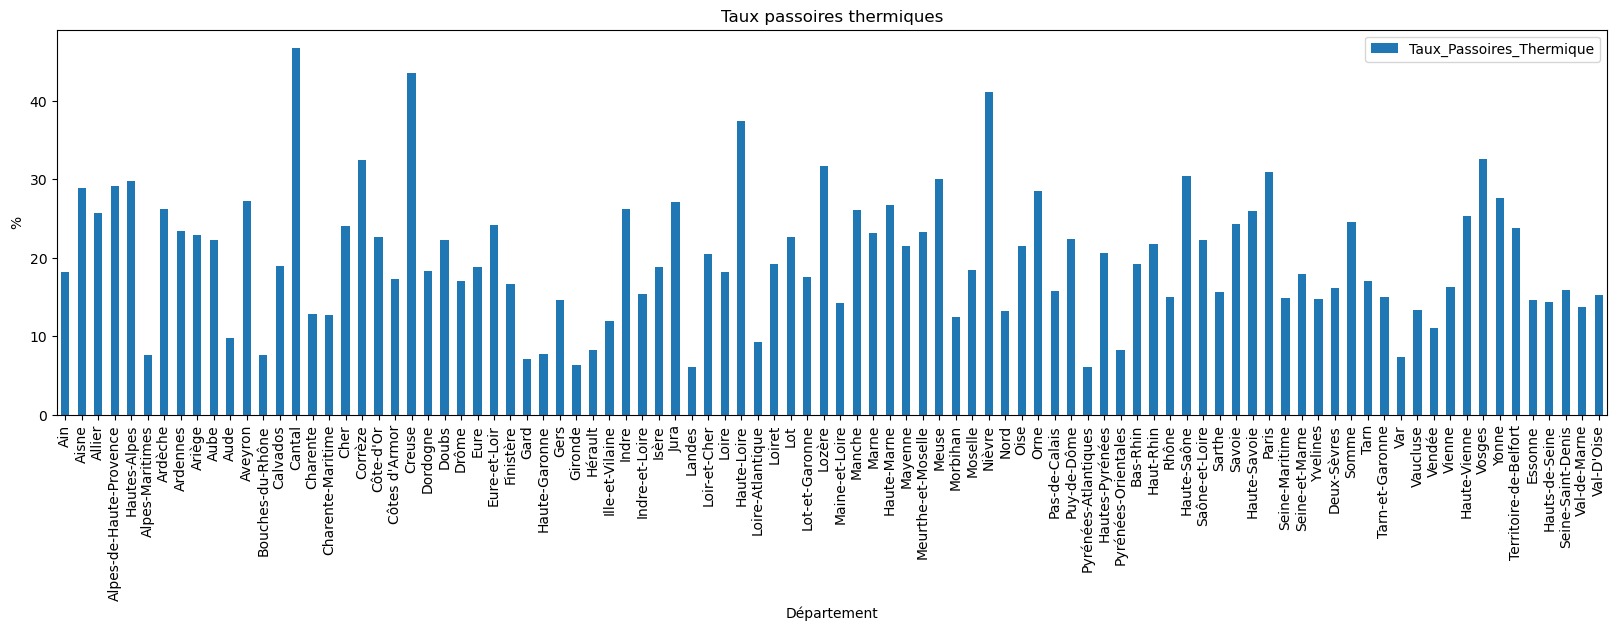

In [101]:
df_to_plot_2 = pd.DataFrame(df_bdd_nat_work,columns=['Département_nom','Taux_Passoires_Thermique'])
df_to_plot_2.plot(x ='Département_nom', y='Taux_Passoires_Thermique', kind = 'bar', figsize=(20,5), title="Taux passoires thermiques")
plt.xlabel('Département')
plt.ylabel('%')
plt.show()

## 2.2. Un peu de visualisation spatiale

On commence par importer ce qu'il nous faut

In [67]:
from cartiflette.download import get_vectorfile_ign

opendatarchives
COG


Downloading: 100%|██████████| 244M/244M [01:46<00:00, 2.39MiB/s] 
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [70]:
france = get_vectorfile_ign(
  level = "COMMUNE",
  field = "metropole",
  source = "COG",
  provider="opendatarchives"
  )

opendatarchives
COG
Data have been previously downloaded and are still available in /tmp/COG-2022


Ici on va commencer à regrouper comme il nous faut les départements pour la visualisation spatiale

In [71]:
france['surface'] = france.area.div(10**6)

In [72]:
france_copy=france.dissolve(by='INSEE_DEP', aggfunc='sum')

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [73]:
france_copy.head(30) #on voit que la Corse est présente en bas du tableau, on va devoir l'enlever

,geometry,POPULATION,surface
INSEE_DEP,,,
01,"POLYGON ((843069.400 6536413.800, 843056.900 6...",652432,5774.264919
02,"POLYGON ((718664.700 6873887.300, 718653.100 6...",531345,7418.591125
03,"POLYGON ((673871.400 6559735.100, 673865.200 6...",335975,7365.660274
04,"POLYGON ((922047.200 6296459.200, 922042.000 6...",164308,6994.193101
05,"POLYGON ((920018.300 6349446.500, 920013.800 6...",141220,5685.026797
06,"MULTIPOLYGON (((1018370.500 6272965.900, 10183...",1094283,4294.731822
07,"POLYGON ((793916.400 6358337.200, 793909.200 6...",328278,5561.382596
08,"POLYGON ((789815.800 6920910.600, 789812.700 6...",270582,5251.889410
09,"POLYGON ((554811.200 6182542.800, 554807.900 6...",153287,4921.022056


In [74]:
#à ne compiler qu'une fois

france_copy.drop('2A',axis=0,inplace=True)
france_copy.drop('2B',axis=0,inplace=True)

# on a rendu son indépendance à la corse

In [78]:
DPE_liste=df_bdd_nat_work['DPE_Moyen'].tolist() 

france_DPE = france_copy.assign(DPE=DPE_liste)
france_DPE

,geometry,POPULATION,surface,DPE
INSEE_DEP,,,,
01,"POLYGON ((843069.400 6536413.800, 843056.900 6...",652432,5774.264919,4.325929
02,"POLYGON ((718664.700 6873887.300, 718653.100 6...",531345,7418.591125,4.862776
03,"POLYGON ((673871.400 6559735.100, 673865.200 6...",335975,7365.660274,4.723923
04,"POLYGON ((922047.200 6296459.200, 922042.000 6...",164308,6994.193101,4.778268
05,"POLYGON ((920018.300 6349446.500, 920013.800 6...",141220,5685.026797,4.856483
...,...,...,...,...
91,"POLYGON ((622877.700 6801316.200, 622850.700 6...",1301659,1818.556444,4.402458
92,"POLYGON ((643324.900 6852986.700, 643317.100 6...",1624357,175.570732,4.367739
93,"POLYGON ((657256.900 6861184.400, 657195.100 6...",1644903,236.867946,4.370616


<AxesSubplot: title={'center': 'DPE Moyens sur le territoire, A=1, G=7'}>

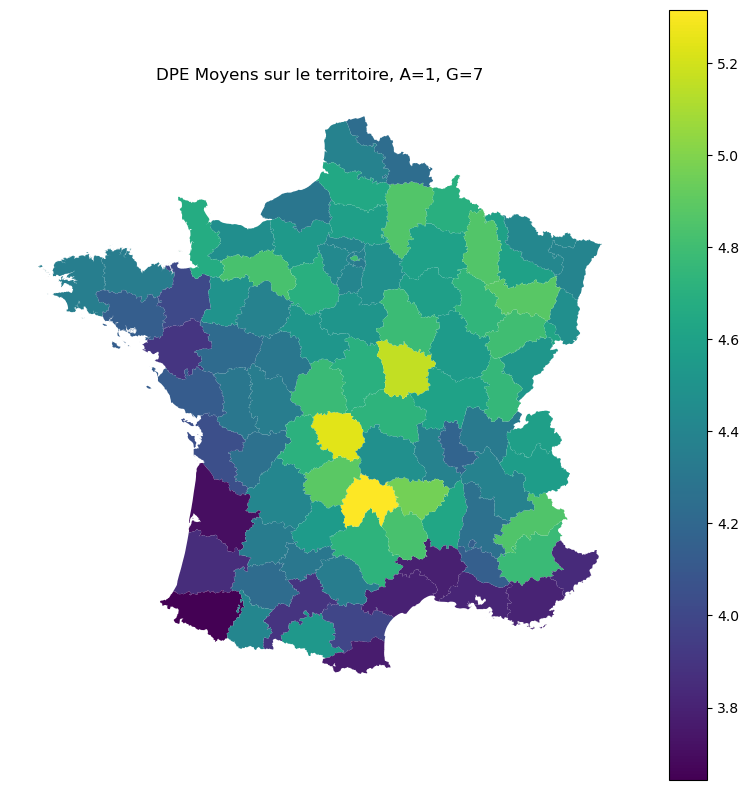

In [79]:
fig,ax = plt.subplots(figsize=(10, 10))
france_DPE.plot(ax = ax, column = "DPE", legend=True)
ax.set_axis_off()
plt.title('DPE Moyens sur le territoire, A=1, G=7')
ax

In [87]:
passoires=df_bdd_nat_work['Taux_Passoires_Thermique'].tolist() 
france_passoires = france_copy.assign(passoires=passoires)
france_passoires

,geometry,POPULATION,surface,passoires
INSEE_DEP,,,,
01,"POLYGON ((843069.400 6536413.800, 843056.900 6...",652432,5774.264919,18.219730
02,"POLYGON ((718664.700 6873887.300, 718653.100 6...",531345,7418.591125,28.873883
03,"POLYGON ((673871.400 6559735.100, 673865.200 6...",335975,7365.660274,25.744696
04,"POLYGON ((922047.200 6296459.200, 922042.000 6...",164308,6994.193101,29.176637
05,"POLYGON ((920018.300 6349446.500, 920013.800 6...",141220,5685.026797,29.757824
...,...,...,...,...
91,"POLYGON ((622877.700 6801316.200, 622850.700 6...",1301659,1818.556444,14.624251
92,"POLYGON ((643324.900 6852986.700, 643317.100 6...",1624357,175.570732,14.376621
93,"POLYGON ((657256.900 6861184.400, 657195.100 6...",1644903,236.867946,15.940095


<AxesSubplot: title={'center': 'Taux de passoires thermiques'}>

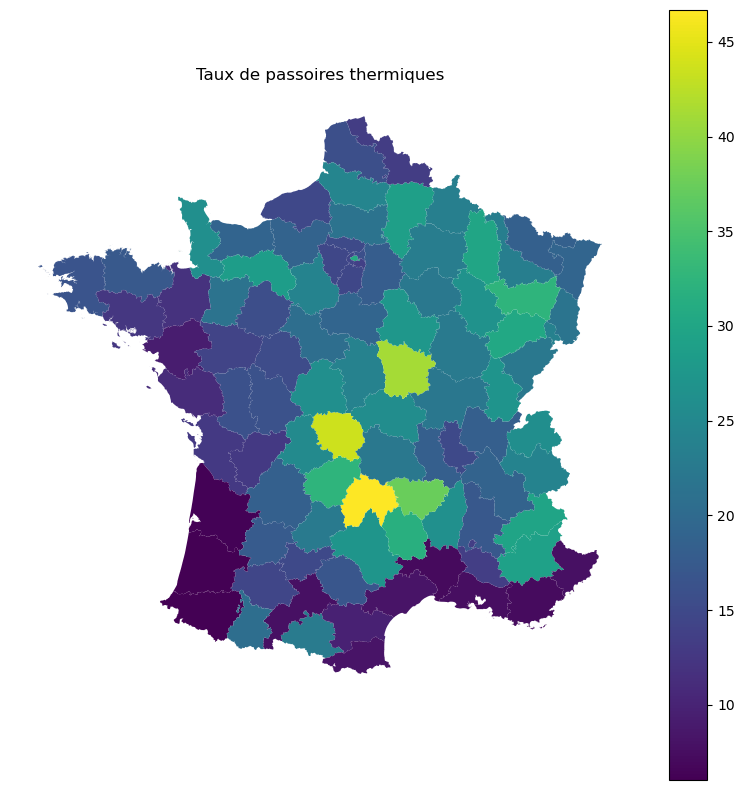

In [88]:
fig,ax = plt.subplots(figsize=(10, 10))
france_passoires.plot(ax = ax, column = "passoires", legend=True)
ax.set_axis_off()
plt.title('Taux de passoires thermiques')
ax